In [1]:
#!/usr/bin/env python3

# Script to load the CLIMATE DATA .Rdata files and grid them and convert them to netcdf files per variable
# uses the .RData files retrieved from the RMI Oracle databse through the climate_grid_daily.txt script from Bert Van Schaeybroeck

# I. Vanderkelen, June 2024

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import xarray as xr
import pandas as pd
from datetime import date
import numpy as np

# activate r to pandas convertor
pandas2ri.activate()


# user settings
variables = ["EVAPOTRANS_REF"]
#], "SUN_INT", "SUN_DURATION", "PRECIP_DURATION", "WIND_PEAK_SPEED", "PRECIP_1H_MAX", "EVAPOTRANS_REF", "TEMP_MAX","HUMIDITY_RELATIVE","TEMP_MIN", "TEMP_AVG", "WIND_SPEED", "PRESSURE", "SHORT_WAVE_FROM_SKY", "SUN_INT_HORIZ", "PRECIP_QUANTITY"]

# load climategrid meta data on variables and units
meta = pd.read_csv('CLIMATE_GRID_meta.csv', delimiter=";")

# load information on projection used 
proj_string = "+proj=lcc +lat_1=49.83333388888889 +lat_2=51.16666722222222 +lat_0=90 +lon_0=4.367486666666666 +x_0=150000.013 +y_0=5400088.438 +ellps=intl +units=m +no_defs"


start_yr = 1950
end_yr = 2023
dates = pd.date_range(start=f'{start_yr}-01-01', end=f'{end_yr}-12-31', freq='D')

data_dir = '/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/'


for variable in variables: 
	print('Converting '+ variable)

	filename = 'climate_atlas_'+str(variable)+'_CLIMATE_GRID_'+str(start_yr)+'_'+str(end_yr)+'.Rdata'

	# load the robject
	robjects.r['load'](data_dir+filename)

	# load the pixel lat and lon variable and use this to transpose to own defined grid
	df_coords =  pandas2ri.rpy2py(robjects.r['grid.pt.lst'])


	# define own grid  (in the original data, the delta's are not always the same, but the overall distance is similar)
	lons = df_coords['PIXEL_LON_CENTER']
	lon_min = lons.min()
	lon_max = lons.max()
	delta_lon = 0.0699 #°
	lon_grid = np.arange(lon_min,lon_max+delta_lon,delta_lon)

	lats = df_coords['PIXEL_LAT_CENTER']
	lat_min = lats.min()
	lat_max = lats.max()
	delta_lat = 0.045 #°
	lat_grid = np.arange(lat_min,lat_max+delta_lat,delta_lat)


	# Find the nearest index in the lons and lats grids and add this to coordinates dataframe
	def find_nearest(array, value):
		idx = (np.abs(array - value)).argmin()
		return idx

	df_coords['LON_INDEX'] = df_coords['PIXEL_LON_CENTER'].apply(lambda x: find_nearest(lon_grid, x))
	df_coords['LAT_INDEX'] = df_coords['PIXEL_LAT_CENTER'].apply(lambda x: find_nearest(lat_grid, x))


	# load the vector data
	data_raw = robjects.r['grid.arr']

	#reshape around time-axis
	ntime = data_raw.shape[1] * data_raw.shape[2] * data_raw.shape[3]
	data = data_raw.reshape(1360, ntime)

	# reshape around lat lon axis

	# create empty array to fill with gridded data
	grid_data = np.full(( ntime,  len(lat_grid),len(lon_grid)  ), np.nan)

	# Fill the grid data array
	for index, row in df_coords.iterrows():
		lat_idx = int(row['LAT_INDEX'])
		lon_idx = int(row['LON_INDEX'])
		pixel_id = int(row['PIXEL_ID'])
		
		grid_data[:, lat_idx, lon_idx ] = data[int(pixel_id) - 1, :]


	# time selection - the GRIDDATA is downloaded up to the last day 
	# only select full years here
	grid_data = grid_data[:len(dates),:,:]


	# get metadata from meta dataframe
	unit = meta.loc[meta['variable'] == variable, 'unit'].values[0] 
	long_name = meta.loc[meta['variable'] == variable, 'long_name'].values[0] 
	description = meta.loc[meta['variable'] == variable, 'description'].values[0] 

	# create data array
	da = xr.DataArray(
		data=grid_data,
		dims=["time",  "lat", "lon"],
		coords=dict(
			lon=lon_grid,
			lat=lat_grid,
			time=dates,
		),
		attrs=dict(
			long_name=long_name,
			description = description,
			units=unit,
		),
	)

	da['lat'].attrs = {'units':"degrees_north", 'long_name': "latitude"}
	da['lon'].attrs = {'units':"degrees_east", 'long_name': "longitude"}

	# convert to dataset and give dataset attributes
	ds = da.to_dataset(name=variable)
	d_attrs = {"creation_date": date.today().strftime("%d-%m-%Y"), "creators": "Ghilain N., Van Schaeybroeck B., Vanderkelen I.", 
	"contact": "inne.vanderkelen@meteo.be", "version": "1.1", "affiliation": "Royal Meteorological Institute of Belgium"}
	ds.attrs = d_attrs

	# export to netcdf
	filename_out = str(variable)+'_CLIMATE_GRID_'+str(start_yr)+'_'+str(end_yr)+'_daily.nc'
	ds.to_netcdf(data_dir + filename_out, encoding={'time':  {'dtype': 'int32'} })



Converting EVAPOTRANS_REF


In [2]:
robjects.r['load'](data_dir + filename)

# List all objects in the R environment
all_objects = robjects.r.ls()

# Print all objects
print("Objects in R environment after loading the file:")
for obj in all_objects:
    print(obj)

Objects in R environment after loading the file:
grid.arr
grid.pt.lst
grid.vec
munic.arr
munic.vec


In [23]:
#!/usr/bin/env python3

# Script to load the CLIMATE DATA .Rdata files and grid them and convert them to netcdf files per variable
# uses the .RData files retrieved from the RMI Oracle databse through the climate_grid_daily.txt script from Bert Van Schaeybroeck

# I. Vanderkelen, June 2024

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import xarray as xr
import pandas as pd
from datetime import date
import numpy as np

# activate r to pandas convertor
pandas2ri.activate()


# user settings
variables = ["TEMP_MAX"]
#"EVAPOTRANS_REF", "SUN_INT", "SUN_DURATION", "PRECIP_DURATION", "WIND_PEAK_SPEED", "PRECIP_1H_MAX", "EVAPOTRANS_REF", "TEMP_MAX","HUMIDITY_RELATIVE","TEMP_MIN", "TEMP_AVG", "WIND_SPEED", "PRESSURE", "SHORT_WAVE_FROM_SKY", "SUN_INT_HORIZ", "PRECIP_QUANTITY"]


# INFO ON GRID
# load climategrid meta data on variables and units
meta = pd.read_csv('CLIMATE_GRID_meta.csv', delimiter=";")

# load information on projection used 
proj_string = "+proj=lcc +lat_1=49.83333388888889 +lat_2=51.16666722222222 +lat_0=90 +lon_0=4.367486666666666 +x_0=150000.013 +y_0=5400088.438 +ellps=intl +units=m +no_defs"
# load the pixel lat and lon variable and use this to transpose to own defined grid
df_coords_points = pd.read_csv('grid_5kmx5km.csv',header=1,delimiter=' ') # these are the lat lons and lambert coordinates for all pixels in CLIMATE_DATA


# load the full grid, creased based on the proj_string and following bounding points:
#NE_lon, NE_lat = 9.53269211610237, 53.4367017362904
#SW_lon, SW_lat = 0.163155782953472, 47.515819098539
df_full_grid = pd.read_csv('lambert_coordinates_full_climate_grid.csv') # made using R script Michel Journee
lambert_x_grid_raw = df_full_grid['x1'].unique()
lambert_y_grid_raw = df_full_grid['x2'].unique()

# cut this grid to boundingbox including gridcells from CLIMATE_GRID
lambert_x_grid_cutlow = lambert_x_grid_raw[lambert_x_grid_raw>=df_coords_points['LAMBERT_X'].min()]
lambert_x_grid = lambert_x_grid_cutlow[lambert_x_grid_cutlow<=  df_coords_points['LAMBERT_X'].max()]
lambert_y_grid_cutlow = lambert_y_grid_raw[lambert_y_grid_raw>=df_coords_points['LAMBERT_Y'].min()]
lambert_y_grid = lambert_y_grid_cutlow[lambert_y_grid_cutlow<=  df_coords_points['LAMBERT_Y'].max()]


# Find the nearest index in the lons and lats grids and add this to coordinates dataframe
def find_nearest(array, value):
	idx = (np.abs(array - value)).argmin()
	return idx

df_coords_points['LAMBERT_X_INDEX'] = df_coords_points['LAMBERT_X'].apply(lambda x: find_nearest(lambert_x_grid, x))
df_coords_points['LAMBERT_Y_INDEX'] = df_coords_points['LAMBERT_Y'].apply(lambda x: find_nearest(lambert_y_grid, x))


data_dir = '/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/'

for variable in variables: 
	print('Converting '+ variable)

	filename = 'climate_atlas_'+str(variable)+'_CLIMATE_GRID_1950_2023.Rdata'

	# load the robject
	robjects.r['load'](data_dir+filename)


	# load the time data and convert to dates
	time = robjects.r['time.lst']
	dates = pd.to_datetime(time)

	# load the vector data
	data = robjects.r['grid.vec']

	# create empty array to fill with gridded data - also for lat and lon
	grid_data = np.full(( len(dates),  len(lambert_y_grid),len(lambert_x_grid)  ), np.nan)

	lat_2d = np.full((len(lambert_y_grid),len(lambert_x_grid)  ), np.nan)
	lon_2d = np.full((len(lambert_y_grid),len(lambert_x_grid)  ), np.nan)

	# Fill the grid data array
	for index, row in df_coords_points.iterrows():
		lambert_x_idx = int(row['LAMBERT_Y_INDEX'])
		lambert_y_idx = int(row['LAMBERT_X_INDEX'])

		pixel_id = int(row['PIXEL_ID'])
		
		grid_data[:, lambert_x_idx, lambert_y_idx ] = data[int(pixel_id) - 1, :]

		lat_2d[ lambert_x_idx, lambert_y_idx ] = df_coords_points[df_coords_points['PIXEL_ID'] == pixel_id]["LAT"].values[0]
		lon_2d[ lambert_x_idx, lambert_y_idx ] = df_coords_points[df_coords_points['PIXEL_ID'] == pixel_id]["LON"].values[0]


	# get metadata from meta dataframe
	unit = meta.loc[meta['variable'] == variable, 'unit'].values[0] 
	long_name = meta.loc[meta['variable'] == variable, 'long_name'].values[0] 
	description = meta.loc[meta['variable'] == variable, 'description'].values[0] 

	# create data array
	da = xr.DataArray(
		data=grid_data,
		dims=["time", "y", "x"],
		coords=dict(
			y=lambert_y_grid,
			x=lambert_x_grid,
			time=dates,
		),
		attrs=dict(
			long_name=long_name,
			description = description,
			units=unit,
		),
	)


	da['x'].attrs = {'units':"E[east]: Easting (meters)", 'long_name': " x coordinate Lambert Conic Conformal (2SP)"}
	da['y'].attrs = {'units':"N[north]: Northing (meters)", 'long_name': "y coordinate Lambert Conic Conformal (2SP)"}

	# convert to dataset and give dataset attributes
	ds = da.to_dataset(name=variable)

	# add 2d lat and lon in lambert coordinates as well
	ds["lat"] = xr.DataArray(
		data=lat_2d,
		dims=["y", "x"],
		coords=dict(
			y=lambert_y_grid,
			x=lambert_x_grid,
		),
		attrs=dict(
			long_name="latitude",
			description = "WGS84 latitude, from values of CLIMATE_GRID, provided per grid point",
			units="degrees_north",
		),
	)

	ds["lon"] = xr.DataArray(
		data=lon_2d,
		dims=["y", "x"],
		coords=dict(
			y=lambert_y_grid,
			x=lambert_x_grid,
		),
		attrs=dict(
			long_name="longitude",
			description = "WGS84 longitude, from values of CLIMATE_GRID, provided per grid point",
			units="degrees_east",
		),
	)
	d_attrs = {"creation_date": date.today().strftime("%d-%m-%Y"),
	"creators": "Ghilain N., Van Schaeybroeck B., Vanderkelen I.", 
	"contact": "inne.vanderkelen@meteo.be",
	"version": "1.1", "affiliation": "Royal Meteorological Institute of Belgium", 
	"projection":proj_string}
	ds.attrs = d_attrs

	# export to netcdf
	filename_out = str(variable)+'_CLIMATE_GRID_'+str(dates.year.min())+'_'+str(dates.year.max())+'_daily.nc'
	ds.to_netcdf(data_dir + filename_out, encoding={'time':  {'dtype': 'int32'} })



Converting TEMP_MAX


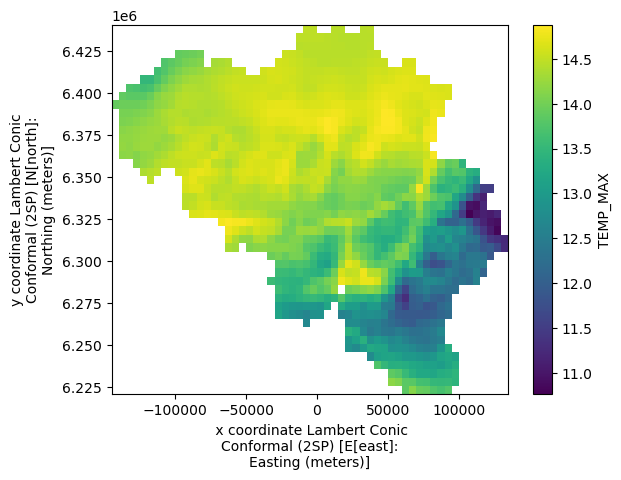

In [28]:
ds[variable].mean('time').plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [9]:
# Do transformation into regulat lat lon (WGS84)
import rioxarray

In [ ]:
da.rio.write_crs(4326, inplace=True)
xda.rio.crs

= xds.rio.reproject("EPSG:4326")

In [3]:
import cartopy.crs as ccrs

# Define the custom projection
proj_string = ds.attrs['projection']
# Create a Cartopy CRS object from the projection string
custom_crs = ccrs.Projection(proj_string)



.to_crs(crs=custom_crs)

In [15]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
import cartopy.crs as ccrs
from shapely.ops import unary_union



# Define the coordinates of NE and SW points
NE_lon, NE_lat = 9.53269211610237, 53.4367017362904
SW_lon, SW_lat = 0.163155782953472, 47.515819098539

# Create data frames for NE and SW points
NE_df = gpd.GeoDataFrame(geometry=[Point(NE_lon, NE_lat)]).set_crs(epsg=4326).to_crs(crs=custom_crs)
SW_df = gpd.GeoDataFrame(geometry=[Point(SW_lon, SW_lat)]).set_crs(epsg=4326).to_crs(crs=custom_crs)

# Define the resolution
resolution = 5000

corners = gpd.GeoDataFrame(geometry=gpd.GeoSeries(unary_union([NE_df.unary_union, SW_df.unary_union])))

# Create the grid
xmin, ymin, xmax, ymax = corners.total_bounds
x = np.arange(np.floor(xmin), np.ceil(xmax), resolution)
y = np.arange(np.floor(ymin), np.ceil(ymax), resolution)
xx, yy = np.meshgrid(x, y)
grid_points = [Point(x, y) for x, y in zip(xx.flatten(), yy.flatten())]
grid = gpd.GeoDataFrame(geometry=grid_points)
grid.crs = custom_crs


# Convert to xarray DataArray
lon = np.unique(grid.geometry.x)
lat = np.unique(grid.geometry.y)
lon_bnds = np.linspace(lon[0] - resolution / 2, lon[-1] + resolution / 2, len(lon))
lat_bnds = np.linspace(lat[0] - resolution / 2, lat[-1] + resolution / 2, len(lat))
da_empty = xr.DataArray(np.zeros((len(lat), len(lon))), coords={'lat': lat, 'lon': lon},
                          dims=['lat', 'lon'], attrs={'crs': custom_crs})
da_empty.attrs['resolution'] = resolution

print(da_empty)



In [33]:
lon

array([-166919., -161919., -156919., -151919., -146919., -141919.,
       -136919., -131919., -126919., -121919., -116919., -111919.,
       -106919., -101919.,  -96919.,  -91919.,  -86919.,  -81919.,
        -76919.,  -71919.,  -66919.,  -61919.,  -56919.,  -51919.,
        -46919.,  -41919.,  -36919.,  -31919.,  -26919.,  -21919.,
        -16919.,  -11919.,   -6919.,   -1919.,    3081.,    8081.,
         13081.,   18081.,   23081.,   28081.,   33081.,   38081.,
         43081.,   48081.,   53081.,   58081.,   63081.,   68081.,
         73081.,   78081.,   83081.,   88081.,   93081.,   98081.,
        103081.,  108081.,  113081.,  118081.,  123081.,  128081.,
        133081.,  138081.,  143081.,  148081.,  153081.,  158081.,
        163081.,  168081.,  173081.,  178081.,  183081.,  188081.,
        193081.,  198081.,  203081.,  208081.,  213081.,  218081.,
        223081.,  228081.,  233081.,  238081.,  243081.,  248081.,
        253081.,  258081.,  263081.,  268081.,  273081.,  2780

array([-327500., -322500., -317500., -312500., -307500., -302500.,
       -297500., -292500., -287500., -282500., -277500., -272500.,
       -267500., -262500., -257500., -252500., -247500., -242500.,
       -237500., -232500., -227500., -222500., -217500., -212500.,
       -207500., -202500., -197500., -192500., -187500., -182500.,
       -177500., -172500., -167500., -162500., -157500., -152500.,
       -147500., -142500., -137500., -132500., -127500., -122500.,
       -117500., -112500., -107500., -102500.,  -97500.,  -92500.,
        -87500.,  -82500.,  -77500.,  -72500.,  -67500.,  -62500.,
        -57500.,  -52500.,  -47500.,  -42500.,  -37500.,  -32500.,
        -27500.,  -22500.,  -17500.,  -12500.,   -7500.,   -2500.,
          2500.,    7500.,   12500.,   17500.,   22500.,   27500.,
         32500.,   37500.,   42500.,   47500.,   52500.,   57500.,
         62500.,   67500.,   72500.,   77500.,   82500.,   87500.,
         92500.,   97500.,  102500.,  107500.,  112500.,  1175

In [25]:
df_bert_coordinaten['x1'].max()

327500.0

In [28]:
df_bert_coordinaten['x2'].min()

6008014.17991319

In [26]:
df_bert_coordinaten['x2'].max()

6663014.17991319

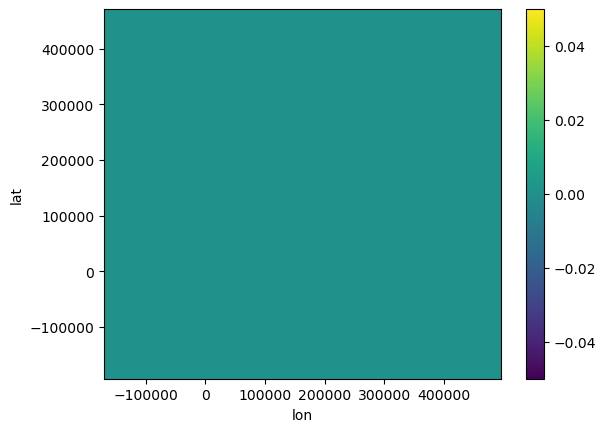

In [19]:
da_empty.plot()